In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
dblock = DataBlock()
dsets = dblock.datasets(df)
len(dsets.train), len(dsets.valid)
x, y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [7]:
x['fname']

'008663.jpg'

In [8]:
dblock = DataBlock(
    get_x = lambda r: r['fname'],
    get_y = lambda r: r['labels']
)
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [10]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = get_x, 
    get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [14]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [15]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

In [19]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [21]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid


In [25]:
dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = splitter,
    get_x = get_x,
    get_y = get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

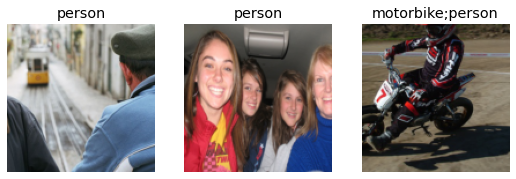

In [28]:
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

# Binary Cross-Entropy

In [29]:
learn = vision_learner(dls, resnet18)
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([64, 20])

mini-batch size = 64, 20 categories

In [31]:
len(activs[0])

20

In [32]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets == 1, inputs, 1 - inputs).log().mean()

In [34]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0801, grad_fn=<AliasBackward0>)

In [35]:
learn = vision_learner(
    dls,
    resnet50,
    metrics = partial(accuracy_multi, thresh=0.2)
)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.936550,0.701281,0.232908,00:16
1,0.811779,0.537963,0.294402,00:15
2,0.593496,0.205470,0.805359,00:15
3,0.355892,0.125713,0.943785,00:15


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135697,0.117585,0.946773,00:16
1,0.117746,0.106652,0.954562,00:16
2,0.095943,0.103001,0.953307,00:16


In [36]:
preds, targs = learn.get_preds()

In [37]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9571)

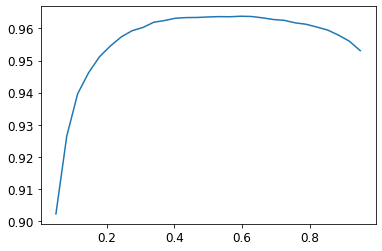

In [38]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

In [39]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

In [40]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [41]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [42]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

In [43]:
img2pose(img_files[0])

Path('06/frame_00554_pose.txt')

In [44]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

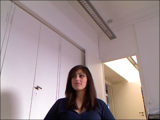

In [45]:
im.to_thumb(160)

In [46]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [47]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name == '13'),
    batch_tfms=aug_transforms(size=(240,320)),
)

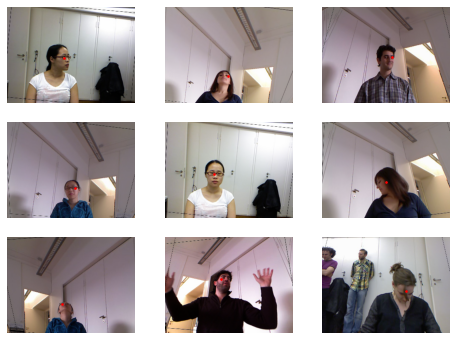

In [49]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n = 9, figsize=(8, 6))

In [50]:
xb, yb = dls.one_batch()

In [54]:
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [55]:
yb[0]

TensorPoint([[0.2403, 0.4678]], device='cuda:0')

# training a model

In [57]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [58]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

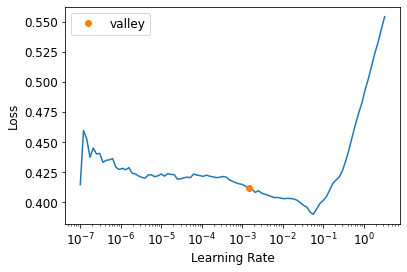

In [59]:
learn.lr_find()

In [60]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051372,0.017143,01:22


epoch,train_loss,valid_loss,time
0,0.008016,0.001597,01:38
1,0.003219,0.000900,01:38
2,0.001511,0.000067,01:38


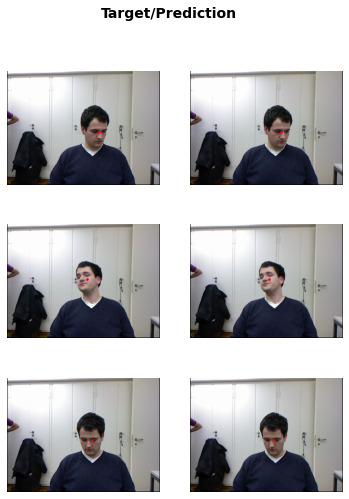

In [63]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

nn.CrossEntropyLoss for single-label classification  
nn.BCEWithLogitsLoss for multi-label classification  
nn.MSELoss for regression  